# Load our data in and take a look at both the raw data and also visualize it

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
silsoJD = pd.read_csv('./sunspot_data/SILSO_daily_inJD.txt', delimiter='\s+', usecols=[0,1,2,3,4], skiprows=1)

silsoJD.columns = ['JD', 'SSN', 'std', 'observations', 'definitive indicator']

In [20]:
silsoJD

,JD,SSN,std,observations,definitive indicator
0,2385070.5,-1.0,-1.0,0.0,1.0
1,2385071.5,-1.0,-1.0,0.0,1.0
2,2385072.5,-1.0,-1.0,0.0,1.0
3,2385073.5,-1.0,-1.0,0.0,1.0
4,2385074.5,-1.0,-1.0,0.0,1.0
...,...,...,...,...,...
73865,2458935.5,0.0,0.0,43.0,0.0
73866,2458936.5,0.0,0.0,39.0,0.0
73867,2458937.5,0.0,0.0,36.0,0.0
73868,2458938.5,4.0,0.2,9.0,0.0


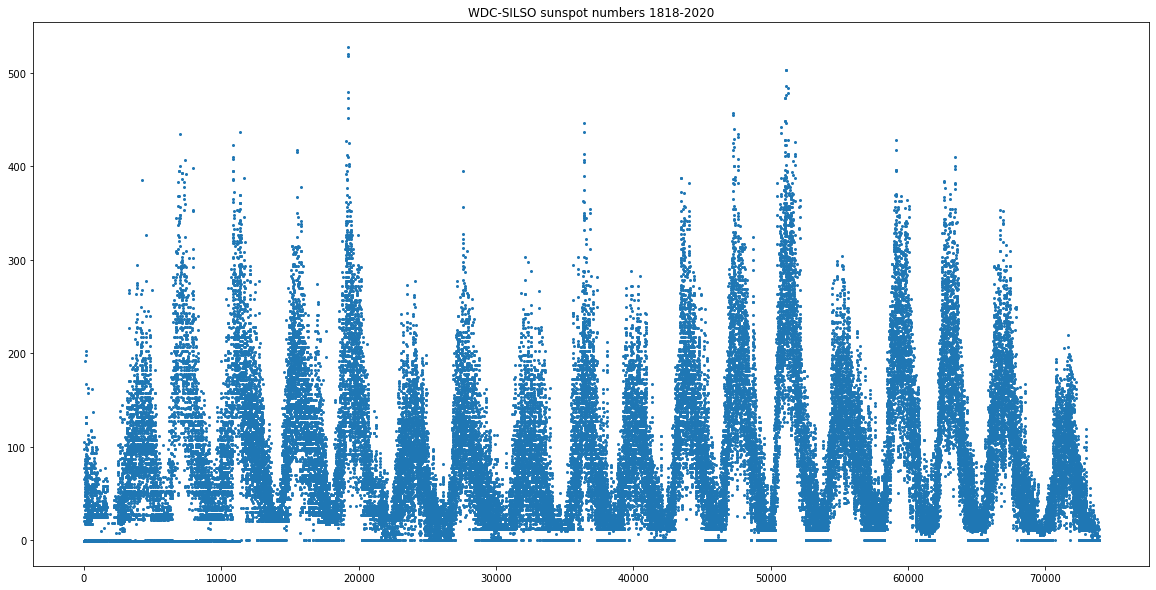

In [229]:
plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020')
plt.scatter(range(len(silsoJD['SSN'])), silsoJD['SSN'], s=4)

#note: value of -1 means no data collected that day. need to cut out

## Take care of that note and clean it up, doesn't really make much of a difference but we'll be thorough anyway

In [62]:
import numpy as np

cleaned_data = silsoJD['SSN'].replace(-1.0, np.nan)
dates = [date for date in range(len(silsoJD['SSN']))]

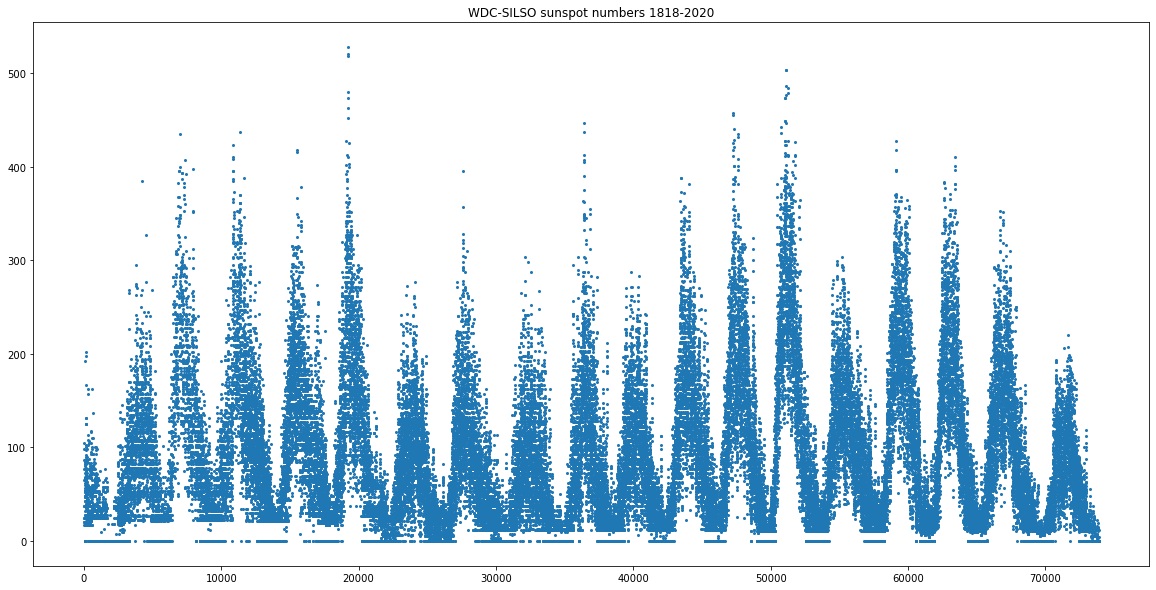

In [63]:
plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020')
plt.scatter(dates, cleaned_data, s=4)

## Some naive guesses at what a model might look like, keep tweaking and adding sine functions until something is reasonable enough to move forward with

In [227]:
#units are JD
period1 = [date/635 + 8.75 for date in dates]
period2 = [date/6000 for date in dates]
period3 = [date/14000 + 35 for date in dates]

#units are counts
amplitude1 = 180 
amplitude2 = 50
amplitude3 = 75

offset1 = 70
offset2 = 50
offset3 = 20

function1 = (amplitude1 * (np.sin(period1)) + offset1)
function2 = (amplitude2 * (np.sin(period2)) + offset2)
function3 = (amplitude3 * (np.sin(period3)) + offset3)

total_function = (function1 + function2 + function3) + silsoJD['std']
total_function[total_function <0] = 0

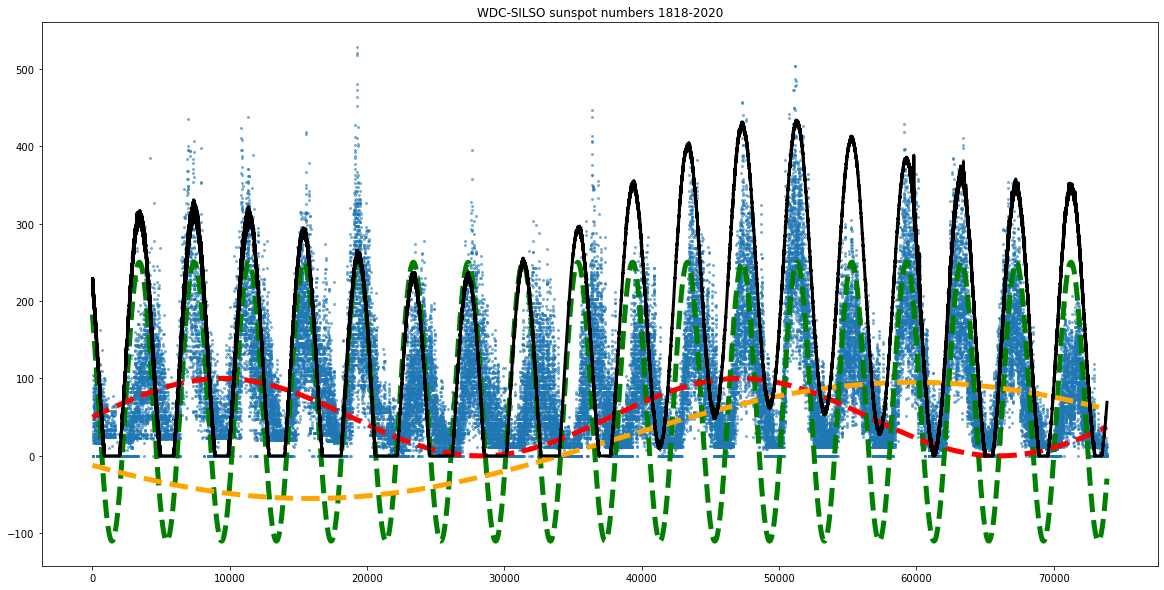

In [228]:
plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020')
plt.scatter(dates, cleaned_data, s=4, alpha=0.5)
plt.plot(dates, function1, c='g', ls='--', linewidth=5)
plt.plot(dates, function2, c='r', ls='--', linewidth=5)
plt.plot(dates, function3, c='orange', ls='--', linewidth=5)
plt.plot(dates, total_function, c='k', linewidth=3)

## Now we can feed this into some random walkers and have that come up with a better fit...........maybe